In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import missingno as msno
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector

from xgboost import XGBRegressor
from joblib import dump, load


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Hitters.csv')
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


<AxesSubplot: >

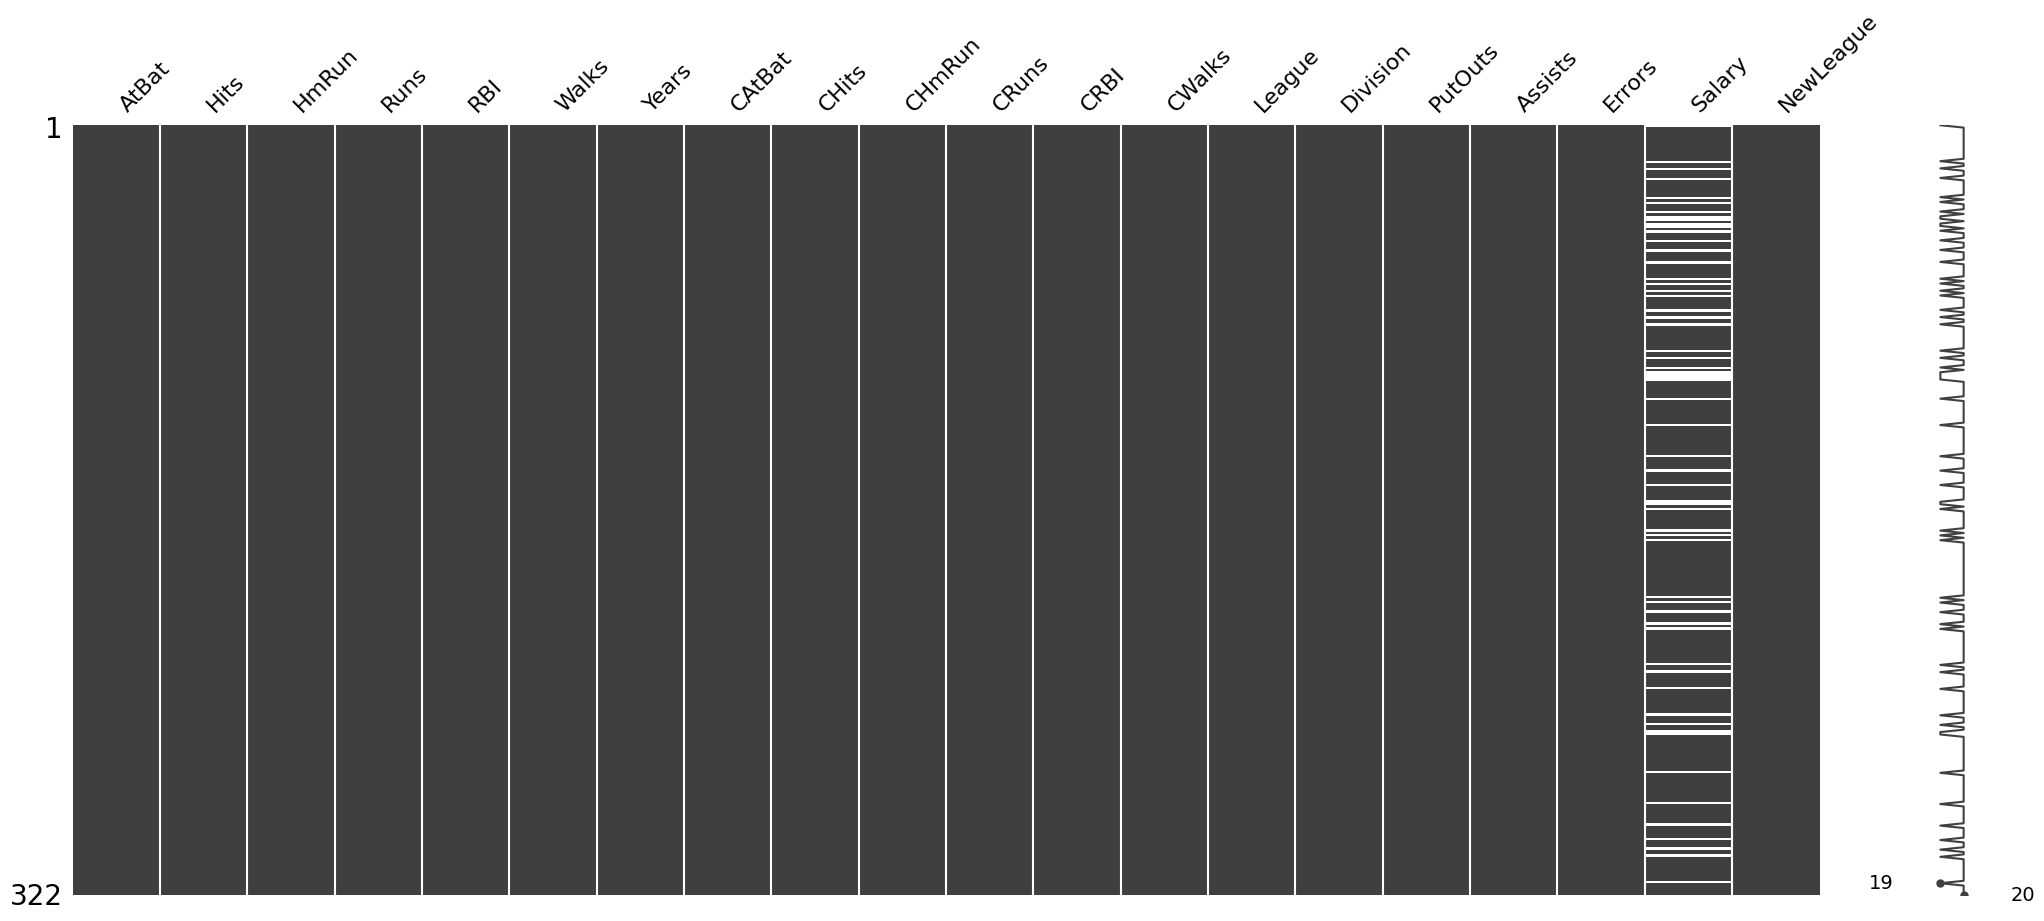

In [3]:
msno.matrix(df)

*Salary distribution*

<AxesSubplot: xlabel='Salary', ylabel='Count'>

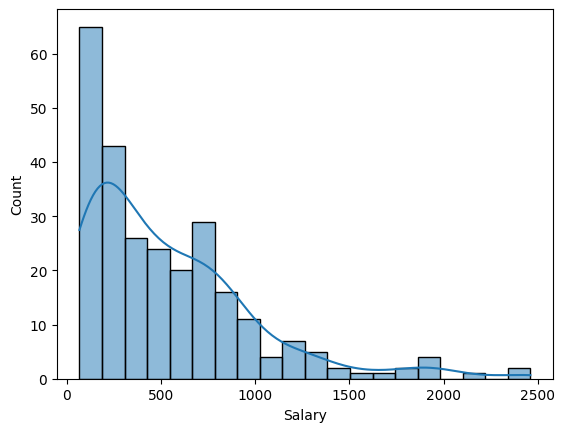

In [4]:
sns.histplot(x='Salary', data=df, bins=20, kde=True)

In [5]:
(df['Salary'].isnull().sum()/df['Salary'].sum())*100

0.041859258573061726

Dealing with missing values in salary column

In [6]:
clean_df =  df.dropna(subset=['Salary'])

Illustrating the correlation between Salary and other features

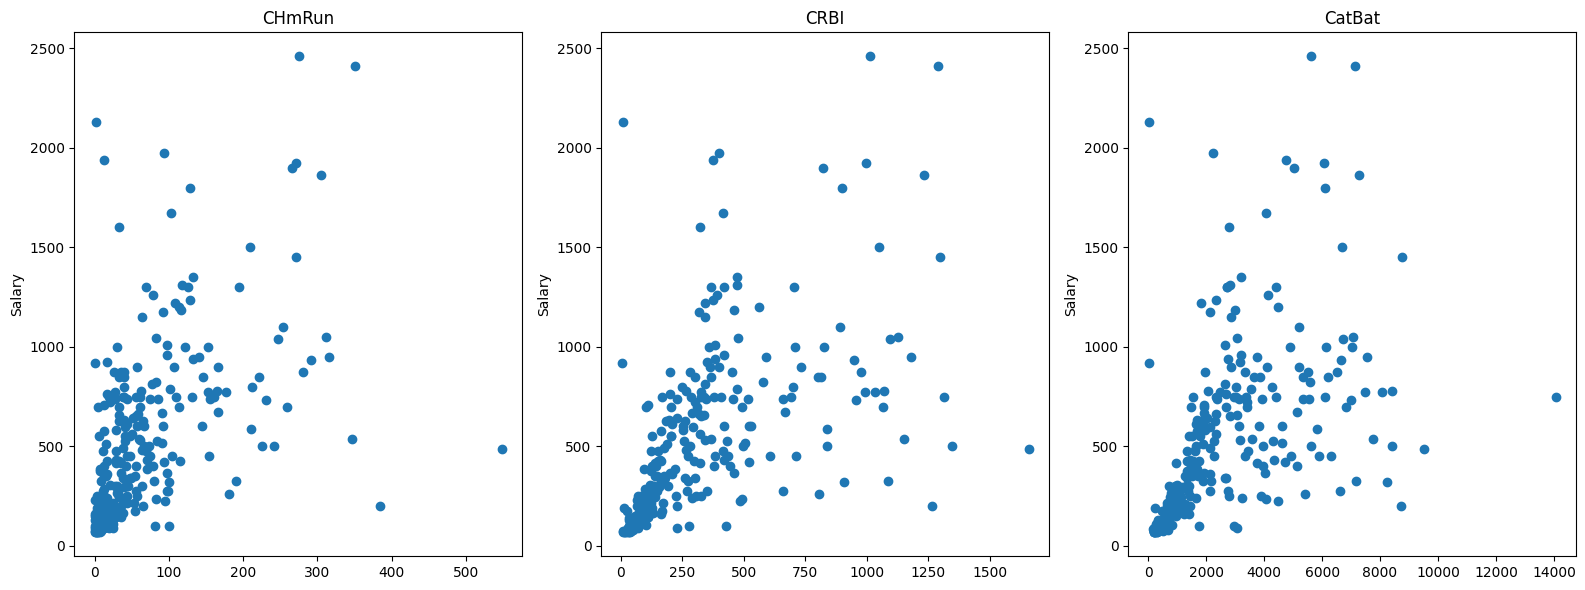

In [7]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,6))

axes[0].plot(clean_df['CHmRun'],clean_df['Salary'],'o')
axes[0].set_ylabel("Salary")
axes[0].set_title("CHmRun")

axes[1].plot(clean_df['CRBI'],clean_df['Salary'],'o')
axes[1].set_title("CRBI")
axes[1].set_ylabel("Salary")

axes[2].plot(clean_df['CAtBat'],clean_df['Salary'],'o')
axes[2].set_title("CatBat");
axes[2].set_ylabel("Salary")
plt.tight_layout();

Experimenting with features combinations to find if there's a better feature for a model

<AxesSubplot: xlabel='Salary', ylabel='CRBIxCRuns'>

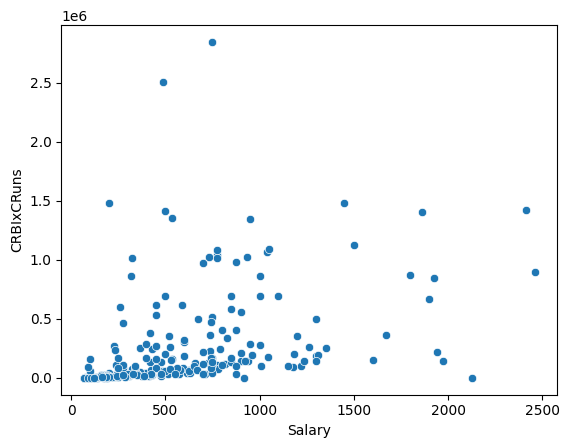

In [8]:
# If combining 2 features provides better correlation
clean_df['CRBIxCRuns'] = clean_df['CRuns']*clean_df['CRBI']
sns.scatterplot(data= clean_df, x='Salary', y='CRBIxCRuns')

<AxesSubplot: xlabel='Salary', ylabel='CRBI^5'>

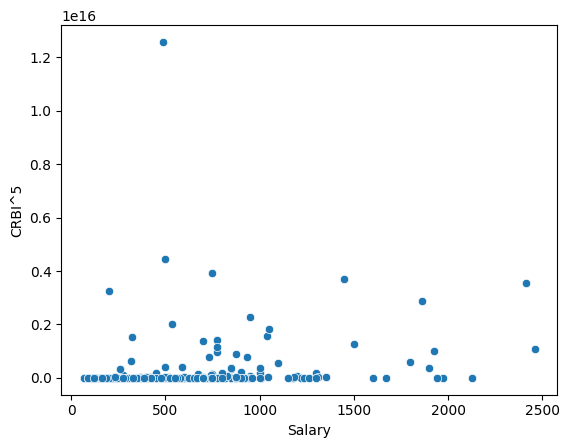

In [9]:
# trying to see if I should apply Polynomial Regression
clean_df['CRBI^5'] = df['CRBI']**5
sns.scatterplot(data=clean_df, x='Salary', y='CRBI^5')

<AxesSubplot: ylabel='Salary'>

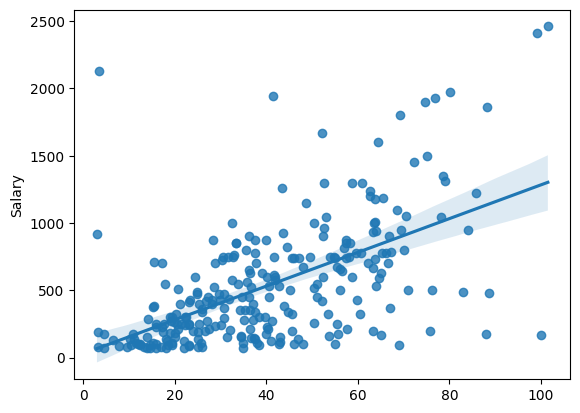

In [10]:
#CRBI/Years
sns.regplot(data=df, x=(df['CRBI']/df['Years']), y=df['Salary'] )

I wanted to understand to see if there's a correlation between league, division, their combinations and salary

In [11]:
df['Division'].unique()

array(['E', 'W'], dtype=object)

In [12]:
df[df['Division'] == 'W']['Salary'].mean()

450.8768731343284

In [13]:
df[df['League'] == 'A']['Salary'].mean()

541.99954676259

In [14]:
df[df['League'] == 'N']['Salary'].mean()

529.1175000000001

In [15]:
df[df['Division'] == 'E']['Salary'].mean()

624.2713643410852

In [16]:
df[(df['League'] == 'A') & (df['Division'] == 'E')]['Salary'].mean()

670.8495588235295

In [17]:
df[(df['League'] == 'N') & (df['Division'] == 'W')]['Salary'].mean()

487.2592698412699

In [18]:
# Trying to understand if I need to add additional features via dummy variables
clean_df['Division_dummies'] = df['Division'].map({'E':1,'W':0})
clean_df.corr(numeric_only=True)['Salary']['Division_dummies']

0.19251439934624648

In [19]:
# Trying to understand if I need to add additional features via dummy variables
clean_df['League_dummies'] = df['League'].map({'N':1,'A':0})
clean_df.corr(numeric_only=True)['Salary']['League_dummies']

-0.014281827480804624

Intentionally adding noise

In [20]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X.iloc[indexes] = np.nan
    return X
def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace = False ) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,),np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X


In [21]:
# Adding NOISE
noisy_df1 = clean_df.apply(lambda col: add_missing(col,amount=0.05))
noisy_df = add_missing_rows(noisy_df1, amount=0.05)

<AxesSubplot: >

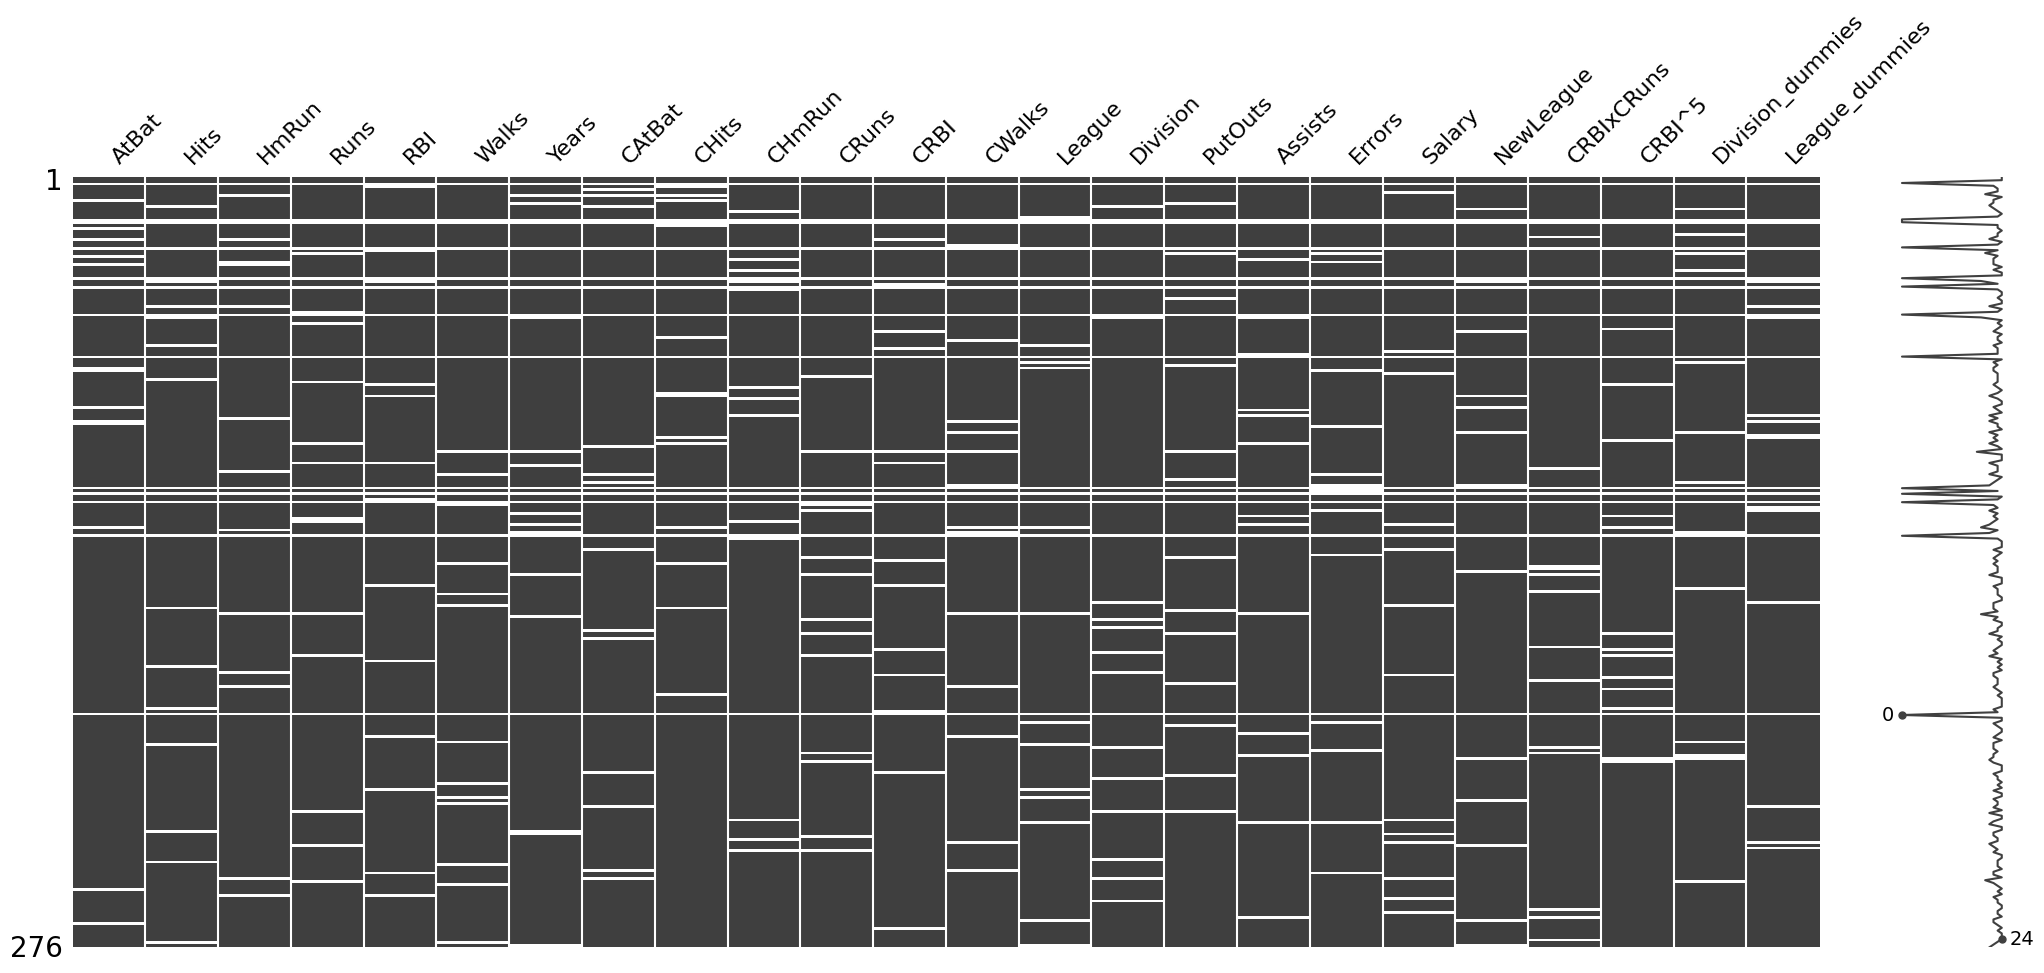

In [22]:
msno.matrix(noisy_df)

In [23]:
X = noisy_df.drop(columns=['Salary'])
y = noisy_df['Salary']

As Pipeline and RandomSearchCV didn't affect y's noise, I decided to do it manually, so my RandomSearchCV works

In [24]:
y_imputer = SimpleImputer(strategy='mean') 

In [ ]:
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()
print("Number of NaN in y after imputation:", pd.isna(y).sum())

In [26]:
noisy_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,Division,PutOuts,Assists,Errors,Salary,NewLeague,CRBIxCRuns,CRBI^5,Division_dummies,League_dummies
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,...,W,632.0,43.0,10.0,475.0,N,132894.0,1.216191e+13,0.0,1.0
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,...,W,880.0,82.0,14.0,480.0,A,59584.0,1.331705e+12,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,496.0,141.0,20.0,65.0,NaN,37.0,11.0,5628.0,NaN,225.0,...,E,200.0,11.0,3.0,500.0,N,693864.0,4.132569e+14,1.0,1.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,NaN,101.0,12.0,...,E,805.0,40.0,4.0,91.5,N,2208.0,2.059630e+08,1.0,1.0


In [27]:
X.shape

(276, 23)

In [28]:
y.shape

(276,)

In [29]:
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=111)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.33, random_state=111)

Pipeline setting

In [30]:
categorical_cols = ['League', 'Division', 'NewLeague']
numerical_cols = [column for column in X_train.columns if column not in categorical_cols]


In [31]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

In [32]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

In [34]:
model = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(eval_metric='rmse')
}

In [35]:
param_grid = [
     {
        'feature_selection__estimator':[LinearRegression()],
        'model': [LinearRegression()],
    },
    {
        'feature_selection__estimator':[ElasticNet()],
        'model': [ElasticNet()],
        'model__alpha':[0.1,0.5,1]
    },
    {
        'feature_selection__estimator':[RandomForestRegressor()],
        'model': [RandomForestRegressor(n_estimators=50, max_depth=10)],
    },
    {
        'feature_selection__estimator':[XGBRegressor(eval_metric='rmse')],
        'model': [XGBRegressor(eval_metric='rmse')],
    }

]

In [36]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SequentialFeatureSelector(LinearRegression(), n_features_to_select=10, direction='backward')),
    ('model', RandomForestRegressor())
]
)

I wanted to compare feature selection via correlation and via SFS

In [37]:
# SFS VS CORRELATION
X1 = clean_df.drop(['Salary', 'NewLeague', 'Division', 'League'], axis=1)
y1 = clean_df['Salary']

In [38]:
SFS = SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10, cv=5, direction='backward')

In [39]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=101)

In [40]:
SFS.fit(X_train1, y_train1)

SequentialFeatureSelector(direction='backward', estimator=LinearRegression(),
                          n_features_to_select=10)

In [41]:
sfs_features = X_train1.columns[SFS.get_support()].tolist()

In [42]:
clean_df.corr(numeric_only=True)['Salary'].sort_values(ascending=False)

Salary              1.000000
CRBI                0.566966
CRuns               0.562678
CHits               0.548910
CAtBat              0.526135
CHmRun              0.524931
CWalks              0.489822
RBI                 0.449457
Walks               0.443867
Hits                0.438675
CRBIxCRuns          0.436560
Runs                0.419859
Years               0.400657
AtBat               0.394771
HmRun               0.343028
PutOuts             0.300480
CRBI^5              0.206056
Division_dummies    0.192514
Assists             0.025436
Errors             -0.005401
League_dummies     -0.014282
Name: Salary, dtype: float64

In [43]:
sfs_features

['AtBat',
 'Hits',
 'Runs',
 'Walks',
 'Years',
 'CAtBat',
 'CRuns',
 'CRBI',
 'PutOuts',
 'CRBIxCRuns']

<AxesSubplot: >

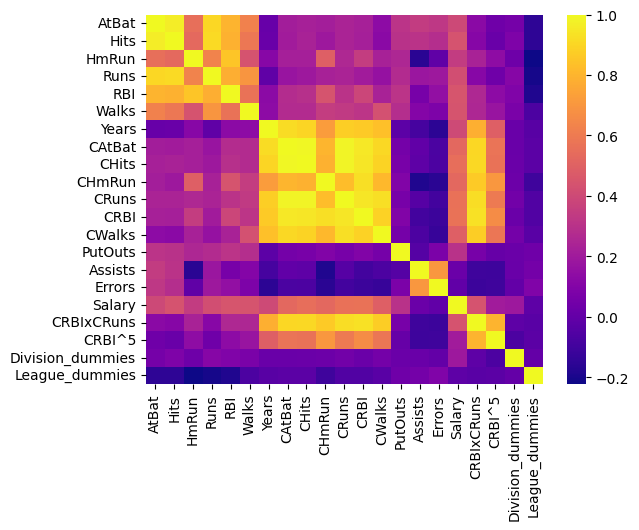

In [44]:
# Feature selection
sns.heatmap(clean_df.select_dtypes(include=['number']).corr(), cmap='plasma')

Seeing the overall percentage of noise added

In [45]:
noisy_df.isnull().sum().sum()/(noisy_df.shape[0]*noisy_df.shape[1])*100

9.420289855072465

Using RandomizedSearchCV to find the best model

In [46]:
randcv = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error',n_iter=10, n_jobs=-1, error_score='raise')

In [47]:
randcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['AtBat',
                                                                                'Hits',
                                                                                'HmRun',
                                                                                'Runs',
                                                                                'RBI',
                                                                                'Walks',
                                                                                'Years',
                                                                                'CAtBat',
                                                                                'CHits',
                                                                                'CHmRun',
                                                                                'CRuns',
                                                                                'CRBI',
                                                                                'CWalks',
                                                                                'PutOuts',
                                                                                'Assists',
                                                                                'Errors',
                                                                                'CRBIxCRuns',
                                                                                'CRBI^...
                                                                interaction_constraints=None,
                                                                learning_rate=None,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=None,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=None, ...)]}],
                   scoring='neg_mean_squared_error')

In [48]:
randcv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors',
                                                   'CRBIxCRuns', 'CRBI^5',
                                                   'Division_dummies',
                                                   'League_dummies']),
                                                 ('cat',
                                                  Pipeli...ps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['League', 'Division',
                                                   'NewLeague'])])),
                ('feature_selection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=RandomForestRegressor(),
                                           n_features_to_select=10)),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=50))])

In [49]:
randcv.best_params_

{'model': RandomForestRegressor(max_depth=10, n_estimators=50),
 'feature_selection__estimator': RandomForestRegressor()}

In [50]:
best_model = randcv.best_estimator_

In [51]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors',
                                                   'CRBIxCRuns', 'CRBI^5',
                                                   'Division_dummies',
                                                   'League_dummies']),
                                                 ('cat',
                                                  Pipeli...ps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['League', 'Division',
                                                   'NewLeague'])])),
                ('feature_selection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=RandomForestRegressor(),
                                           n_features_to_select=10)),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=50))])

## FINAL PREDICTIONS

In [52]:
y_val_pred = best_model.predict(X_valid)

In [53]:
RSME_valid =np.sqrt(mean_squared_error(y_valid, y_val_pred))
RSME_valid

278.6659773907125

In [55]:
y_test_pred = best_model.predict(X_test)

In [56]:
RSME_fin = np.sqrt(mean_squared_error(y_test, y_test_pred))
RSME_fin

165.61489285083402

In [57]:
joblib.dump(best_model, 'fin_model!.joblib')

['fin_model!.joblib']

In [59]:
fin_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')

I decided to tune the random forest model's parameters separately because it took too much time if I combined model selection with hyperparameter tuning

In [60]:
# Integrating preprocessor into a pipeline with the RandomForestRegressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])


In [61]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
}

In [62]:
fin_grid = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')

In [63]:
fin_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['AtBat',
                                                                          'Hits',
                                                                          'HmRun',
                                                                          'Runs',
                                                                          'RBI',
                                                                          'Walks',
                                                                          'Years',
                                                                          'CAtBat',
                                                                          'CHits',
                                                                          'CHmRun',
                                                                          'CRuns',
                                                                          'CRBI',
                                                                          'CWalks',
                                                                          'PutOuts',
                                                                          'Assists',
                                                                          'Errors',
                                                                          'CRBIxCRuns',
                                                                          'CRBI^5',
                                                                          'Di...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['League',
                                                                          'Division',
                                                                          'NewLeague'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 20, None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [64]:
tuned_rf = fin_grid.best_estimator_

In [65]:
fin_grid.best_params_

{'regressor__max_depth': 10,
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 100}

In [66]:
rf_valid_preds = tuned_rf.predict(X_valid)

rf_rsme1 = np.sqrt(mean_squared_error(y_valid, rf_valid_preds))
rf_rsme1

276.43325844557666

In [72]:
test_rf_preds = tuned_rf.predict(X_test)
rf_rsme = np.sqrt(mean_squared_error(y_test, test_rf_preds))
rf_rsme

176.23445776776347

In [67]:
# LEARNING CURVE 
train_sizes, train_scores, test_scores = learning_curve(
    estimator=tuned_rf,
    X=X_train,
    y=y_train,
    train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,  
    shuffle=False
)

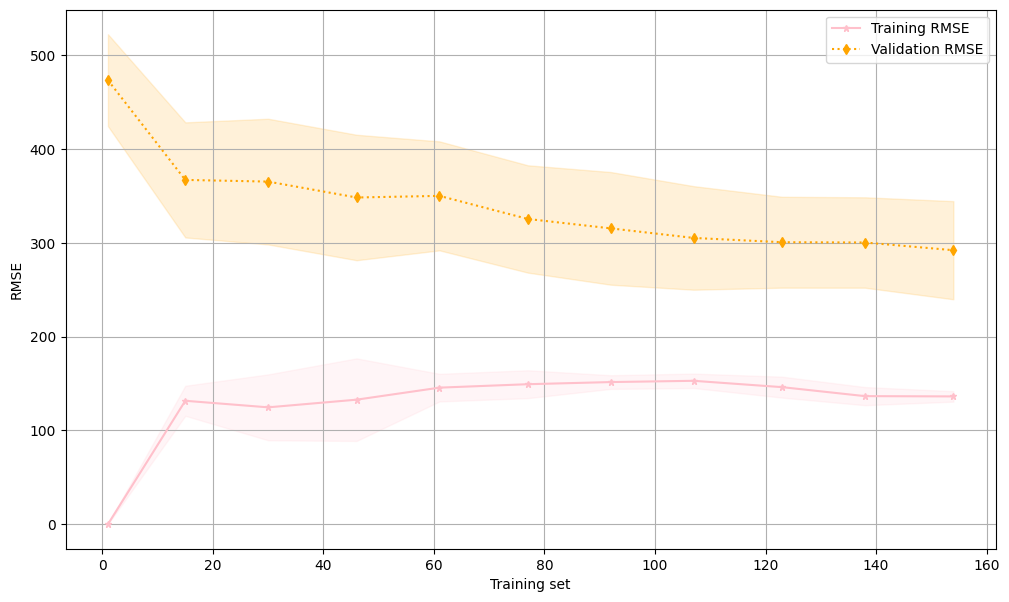

In [68]:
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

train_mean = np.mean(train_rmse, axis=1)
train_std = np.std(train_rmse, axis=1)
test_mean = np.mean(test_rmse, axis=1)
test_std = np.std(test_rmse, axis=1)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

# Training RMSE
ax.plot(train_sizes, train_mean,
         color='pink', marker='*',
         markersize=5, label='Training RMSE')
ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='pink')

# Validation RMSE
ax.plot(train_sizes, test_mean,
         color='orange', linestyle=':',
         marker='d', markersize=5,
         label='Validation RMSE')
ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='orange')

# Add labels and grid
ax.grid()
ax.set_xlabel('Training set')
ax.set_ylabel('RMSE')
ax.legend(loc='upper right')
ax.set_ylim(auto=True)

plt.show()

Using the model to predict a random player's salary

In [90]:
for_prediction = pd.DataFrame([{
    'AtBat': 100, 
    'Hits': 170,
    'HmRun': 99,
    'Runs': 50,
    'RBI': 60,
    'Walks': 40,
    'Years': 5,
    'CAtBat': 100,
    'CHits': 10,
    'CHmRun': 1,
    'CRuns': 999,
    'CRBI': 10,
    'CWalks': 200,
    'PutOuts': 500, 
    'Assists': 180,   
    'Errors': 4,    
    'CRBIxCRuns': 280000, 
    'CRBI^5': 2.329810e+14,    
    'Division_dummies': 0, 
    'League_dummies': 0,
    'League': 'A',
    'Division': 'E',
    'NewLeague': 'A' 
}])

In [96]:
predicted_salary = tuned_rf.predict(for_prediction)

predicted_salary[0]

359.1514893665933

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1d98148e-601d-4d9d-bbd4-eabbc3783172' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>